# MS024 Preprocess
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS024'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS024_SWB2.edf, 276 x 1796032 (1753.9 s), ~3.69 GB, data loaded>

In [7]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'C63',
 'C64',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LAglT10',
 'LAglT11',
 'LAglT12',
 'RAglT1',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6',
 'RAglT7',
 'RAglT8',
 'RAglT9',
 'RAglT10',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LH

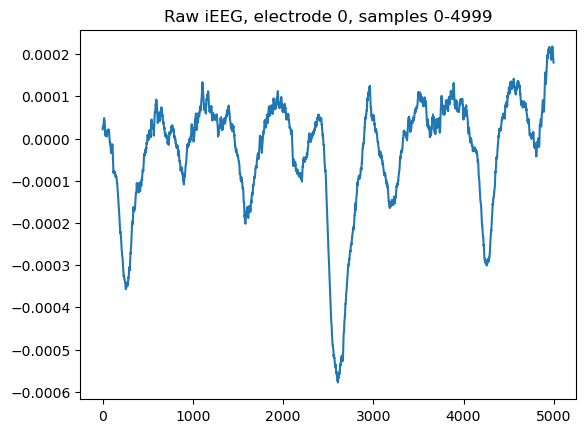

In [8]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

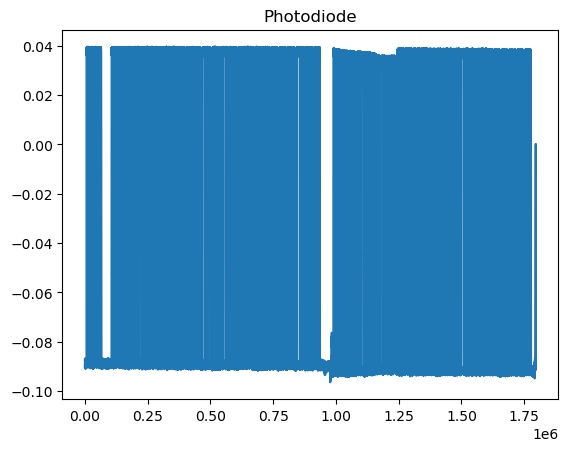

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [10]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -9.585028  33.547612  -8.399996  -7.341464   
1     LaCaS2    A24rv_L -10.383780  35.544494  -3.199996  -7.836954   
2     LaCaS3    A32sg_L -11.182533  37.541376   1.200003  -8.565094   
3     LaCaS4    A32sg_L -11.981285  39.138881   6.000003  -9.278688   
4     LaCaS5     A32p_L -12.780038  40.736386  10.000003  -9.959662   
..       ...        ...        ...        ...        ...        ...   
153   RpTpT6    Unknown  41.535135 -42.333891   2.000003  47.333236   
154   RpTpT7    A39rv_R  45.928274 -43.532020   4.400003  51.611318   
155   RpTpT8    A39rv_R  49.522661 -44.330772   8.000003  55.038627   
156   RpTpT9    A39rv_R  53.915800 -45.528901  10.000003  59.330250   
157  RpTpT10    A39rv_R  57.510186 -45.928278  14.000003  62.666209   

         mni_y      mni_z     gm                                 NMM  \
0    29.783339 -10.461633   Gray  Left ACgG anterior cingulate gyrus   
1    32.391655  -5.187904   Gray  Left ACgG anterior cingulate gyrus   
2    34.852447  -0.672995  White          Left Cerebral White Matter   
3    36.919524   4.361672  White          Left Cerebral White Matter   
4    38.999035   8.575860   Gray  Left ACgG anterior cingulate gyrus   
..         ...        ...    ...                                 ...   
153 -46.351650   3.678801  White         Right Cerebral White Matter   
154 -47.097978   6.009020   Gray         Right Cerebral White Matter   
155 -47.328077   9.797899   Gray     Right MTG middle temporal gyrus   
156 -48.095321  11.780442   Gray     Right MTG middle temporal gyrus   
157 -47.886575  16.104984   Gray             Right AnG angular gyrus   

               Anat                AnatMacro    BN246  \
0          Area s32                    L ACC     L CG   
1          Area s32                    L ACC     L CG   
2           Unknown                    L ACC     L CG   
3           Unknown                    L ACC     L CG   
4           Unknown                    L ACC     L CG   
..              ...                      ...      ...   
153         Unknown                  Unknown  Unknown   
154         Unknown  R Middle Temporal Gyrus    R IPL   
155         Unknown  R Middle Temporal Gyrus    R IPL   
156  Area PGa (IPL)  R Middle Temporal Gyrus    R IPL   
157  Area PGa (IPL)  R Middle Temporal Gyrus    R IPL   

                                      YBA_1 Manual Examination  Notes  
0                    Left cingulate gyrus C                NaN    NaN  
1                    Left cingulate gyrus D                NaN    NaN  
2                    Left cingulate gyrus E                NaN    NaN  
3                                   Unknown                NaN    NaN  
4                    Left cingulate gyrus F                NaN    NaN  
..                                      ...                ...    ...  
153  Right superior middle temporal gyrus F                NaN    NaN  
154  Right superior middle temporal gyrus F                 WM    NaN  
155  Right superior middle temporal gyrus F                NaN    NaN  
156  Right superior middle temporal gyrus F                NaN    NaN  
157         Right superior temporal gyrus G                NaN    NaN  

[158 rows x 16 columns]

In [11]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LAgIT10',
 'LAgIT11',
 'LAgIT12',
 'LaImM1',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM13',
 'LaImM14',
 'LaImM15',
 'LaImM16',
 'LHpIT1',
 'LHpIT2',
 'LHpIT3',
 'LHpIT4',
 'LHpIT5',
 'LHpIT6',
 'LHpIT7',
 'LHpIT8',
 'LHpIT9',
 'LHpIT10',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpTpT1',
 'LpTpT2',
 'LpTpT3',
 'LpTpT4',
 'LpTpT5',
 'LpTpT6',
 'LpTpT7',
 'LpTpT8',
 'LpTpT9',
 'LpTpT10',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'Ra

In [13]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [14]:
unmatched_names

[]

In [15]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [16]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [17]:
new_name_dict

{'LmOlF1': 'lmolf1',
 'LmOlF2': 'lmolf2',
 'LmOlF3': 'lmolf3',
 'LmOlF4': 'lmolf4',
 'LmOlF5': 'lmolf5',
 'LmOlF6': 'lmolf6',
 'LmOlF7': 'lmolf7',
 'LmOlF8': 'lmolf8',
 'LmOlF9': 'lmolf9',
 'RmOlF1': 'rmolf1',
 'RmOlF2': 'rmolf2',
 'RmOlF3': 'rmolf3',
 'RmOlF4': 'rmolf4',
 'RmOlF5': 'rmolf5',
 'RmOlF6': 'rmolf6',
 'RmOlF7': 'rmolf7',
 'RmOlF8': 'rmolf8',
 'RmOlF9': 'rmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'racas11',
 'RaCaS12': 'racas12',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3',
 'LmCmS4': 'lmcms4',
 'LmCmS5': 'lmcms5',
 

In [18]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS024_SWB2.edf, 276 x 1796032 (1753.9 s), ~3.69 GB, data loaded>

In [19]:
unmatched_seeg

[]

In [19]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [20]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 79 left & 79 right sEEG electrodes
We have a total of 158 sEEG electrodes


In [21]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['c254',
 't5',
 'c252',
 'c222',
 'c220',
 'c216',
 'c250',
 'c188',
 'c229',
 'c206',
 'c214',
 'fz',
 'c198',
 'c215',
 'c256',
 'dc13',
 'c249',
 'c63',
 'c240',
 'c233',
 'c243',
 'dc14',
 'o1',
 'ekg2',
 'c231',
 'c227',
 'p4',
 'c207',
 'c199',
 'c230',
 'pleth',
 'c241',
 'c245',
 'c3',
 'ekg1',
 'c194',
 'c208',
 'c190',
 'c218',
 'c221',
 'dc8',
 'pr',
 'fp1',
 't4',
 'c4',
 'c225',
 'dc10',
 'c255',
 'dc5',
 'osat',
 'c244',
 'c200',
 'dc16',
 'c248',
 'c236',
 't3',
 'c205',
 'dc15',
 'pz',
 'c204',
 'f7',
 'c202',
 'f8',
 'c237',
 'c251',
 'c224',
 'c201',
 'c183',
 'c182',
 'cz',
 'c253',
 'c210',
 'c247',
 'c192',
 'c193',
 'c212',
 'dc4',
 'c228',
 'c217',
 'dc11',
 'c196',
 'c235',
 'c232',
 'c187',
 'c223',
 'c239',
 'c209',
 'fp2',
 'c186',
 'c191',
 'f3',
 'c238',
 'trig',
 'dc7',
 'c213',
 'c203',
 'c246',
 'dc2',
 't6',
 'dc9',
 'c197',
 'c185',
 'c234',
 'c189',
 'c226',
 'c64',
 'c211',
 'f4',
 'dc3',
 'p3',
 'c184',
 'dc12',
 'c195',
 'c219',
 'dc6',
 'c242',
 

In [22]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS024_SWB2.edf, 159 x 1796032 (1753.9 s), ~2.13 GB, data loaded>

In [23]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS024_SWB2.edf, 159 x 1796032 (1753.9 s), ~2.13 GB, data loaded>

In [24]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS024_SWB2.edf, 159 x 1796032 (1753.9 s), ~2.13 GB, data loaded>

### Notch filter line noise

In [25]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:    6.8s finished


<RawEDF | MS024_SWB2.edf, 159 x 1796032 (1753.9 s), ~2.13 GB, data loaded>

### Resampling Data

In [26]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 159 out of 159 | elapsed:    9.4s finished


<RawEDF | MS024_SWB2.edf, 159 x 898016 (1753.9 s), ~1.06 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [27]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [28]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [29]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lagit10',
 'lagit11',
 'laimm11',
 'lhpit8',
 'lhpit9',
 'lmcms8',
 'lmcms9',
 'lmolf1',
 'lptpt9',
 'racas7',
 'racas8',
 'racas9',
 'raimm16',
 'rmolf8',
 'rptpt10']

In [30]:
mne_data.info['bads'] = bads

In [31]:
mne_data.info

<Info | 10 non-empty values
 bads: 15 items (lagit10, lagit11, laimm11, lhpit8, lhpit9, lmcms8, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 158 sEEG
 custom_ref_applied: False
 dig: 158 items (158 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 14:32:49 UTC
 nchan: 158
 projs: []
 sfreq: 512.0 Hz
>

In [32]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [33]:
probe_names

array(['lacas', 'lagit', 'laimm', 'lhpit', 'lmcms', 'lmolf', 'lptpt',
       'racas', 'ragit', 'raimm', 'rhpit', 'rmcms', 'rmolf', 'rptpt'],
      dtype='<U5')

In [34]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [35]:
probe_ch_counts

{'lacas': 12,
 'lagit': 12,
 'laimm': 16,
 'lhpit': 10,
 'lmcms': 10,
 'lmolf': 9,
 'lptpt': 10,
 'racas': 12,
 'ragit': 10,
 'raimm': 16,
 'rhpit': 12,
 'rmcms': 10,
 'rmolf': 9,
 'rptpt': 10}

<IPython.core.display.Javascript object>


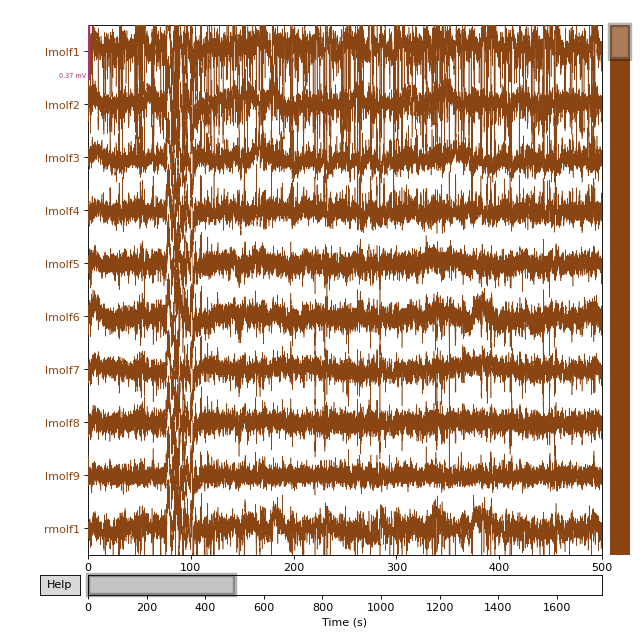

<IPython.core.display.Javascript object>


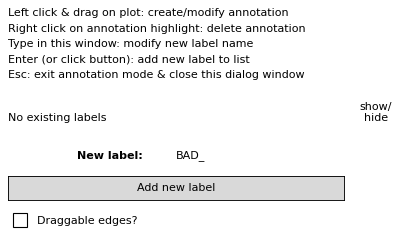

In [38]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [39]:
mne_data.info['bads']

[]

In [40]:
#set bad channel info 
bad_ch = []


In [41]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = bad_ch 

### Rereference data to wm electrodes

In [42]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [43]:
oob_channels

['lacas12',
 'lagit11',
 'lagit12',
 'laimm16',
 'lmcms7',
 'lmcms9',
 'lmcms10',
 'racas12',
 'ragit9',
 'ragit10',
 'raimm16',
 'rhpit12',
 'rmcms9',
 'rmcms10']

In [44]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
bad_ch = bad_ch + oob_channels
bad_ch = list(np.unique(bad_ch))
mne_data.info['bads'] = bad_ch

In [45]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas12',
 'lagit11',
 'lagit12',
 'laimm16',
 'lmcms10',
 'lmcms7',
 'lmcms9',
 'racas12',
 'ragit10',
 'ragit9',
 'raimm16',
 'rhpit12',
 'rmcms10',
 'rmcms9']

In [46]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [47]:
mne_data_reref

<RawEDF | MS024_SWB2.edf, 123 x 898016 (1753.9 s), ~842.9 MB, data loaded>

### Save cleaned continuous data

In [48]:
mne_data.save(f'{neural_dir}{subj_id}/lfp_data.fif',overwrite=True)

In [49]:
mne_data_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)